In [274]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from PIL import Image
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

### **1. Data Validation**

In [275]:
df = pd.read_csv("data/IMDB_Dataset.csv")
df.head(2)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive


Shape of dataset

In [276]:
df.shape

(50000, 2)

Missing Values

In [277]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

Labels

In [278]:
df["sentiment"].value_counts(dropna=False)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Describe

In [279]:
df.describe().T

,count,unique,top,freq
review,50000,49582,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.",5
sentiment,50000,2,positive,25000


### **2. Text Preprocessing**

**2.1. Text Cleaning**

Due to its adverse effect on model performance, unwanted punctuation marks, special characters, HTML tags, numbers, and extra spaces have been removed from the comments, and all characters have been converted to lowercase to achieve a clean format.

In [280]:
def clean_text(text: str) -> str:
    """
    Clean and normalize text by removing HTML tags, punctuation, numbers, and extra whitespace.

    Parameters
    ----------
    text : str
        The input text string to be cleaned.

    Returns
    -------
    str
        The cleaned and normalized text string.
    
    Notes
    -----
    This function performs the following operations:
        - Converts the text to lowercase.
        - Removes punctuation.
        - Removes HTML tags, including <br> tags.
        - Removes numbers.
        - Collapses multiple spaces into a single space and trims leading/trailing spaces.
    """
    text = text.lower() 
    text = re.sub(r"[^\w\s]", "", text)  
    text = re.sub(r"\s*br\s*/?\s*", "", text)
    text = re.sub(r"<.*?>", "", text) 
    text = re.sub(r"\d", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    return text


In [281]:
df["review"] = df["review"].apply(clean_text)

In [282]:
df.sample(2)

,review,sentiment
24518,i couldnt keep from commenting after reading the very short not bad commentary this movie is much better than just not bad the acting is stellar even from the children in the cast who dont play cute or anything else but act just like my sons friends the movie is smart and expects its audience to be as well the double back flash story lines are imaginative and contribute to the story rather than act as time filler i watched this movie with my kids and then i watched it again by myself a few days later if you have kids and are sick to death of movies that inspire a diabetic coma with their syrupy sweetness then check out holes my yearold enjoyed it as much as my yearold and my husband and i enjoyed it as much as the two of them how many movies can you say that about,positive
8561,i have been most fortunate this year to have seen several films at my universitys art museum on occasion well more like half of the time i am unable to watch the films there i have systematically attempted to view each of the films that i have missed so far plagues and pleasures on the salton sea and who killed the electric car are the other films that i have had to watch this way the film covers an intriguing subject matter and is welltheorized emphasis on this later but not as successful as plagues and pleasures but far superior to electric carthe films thesis concerns the future of the american concept of suburban living it questions the feasibility of such a practice as oil prices rise so the film discusses the origin of the suburb and its evolution until the early s one theme the film discusses at length is the alienation the suburb creates among its inhabitants while several people may live together they do not know each other as we define the word this to me represents the strength of the film its appeal to actual human emotion we are able to understand the filmmakers argument so much easier because they do not have to convince us of their arguments legitimacy this is also one of the reasons salton sea is such a wonderful documentaryunfortunately suburbia loses its message in fireand explanation in support of its central argument as those interviewed speak their arguments become progressively more akin to those made by militant environmentalists we are told that oil production will hit its peak in this decade but are given no scientific evidence professional reports statistics graphs etc in support of this claim we are given little information as to how this date was calculated fortunately this was the only significant flaw that i was able to detect in the films argument yet its a glaring one nevertheless another lessimportant discrepancy i noticed was the liberal political bias which could polarize some viewers however this bias is revealed thorough clips of various events and not the filmmakers themselves the clips especially those from the s seemed a tad unnecessary to me the film was no better with their presence and would have been more concise in their absenceas i thought more of this film before composing this review i thought about why i found its argument more convincing than other documentaries that id recently viewed finally i realized that the filmmakers actually offered analysis to the suburban problem they propose a decentralized villagesystem where pockets of people would live together they posit this practice would lower the necessity for fossil fuels and reduce wasted space they define wasted space as the long stretches of parking lots between shopping areas for instance what is incredible about this supposition is that its actually conceivable most documentaries vaguely state that some problem should be ended but offer no method of doing so thinking more about the film i decided that this analysis is what saved the film for me and why i give it a favorable reviewwhile neither perfectly convincing nor fluid in presentation the end of suburbia is a worthwhile investment of ones time it not only addresses th

**2.2. Remove duplicates**

Since identical comments were mixed into the dataset, one instance of each of these comments has been removed from the dataset.

In [283]:
print(f"There are {df["review"].duplicated().sum()} duplicate reviews in imdb dataset")

There are 421 duplicate reviews in imdb dataset


Duplicate Sentences

In [284]:
duplicated_reviews = df[df["review"].duplicated(keep=False)][:3]
duplicated_groups = duplicated_reviews.groupby("review")

for review, group in duplicated_groups:
    print(f"Same sentences:\n {review}")
    print(group)
    print("-" * 100)

Same sentences:
 before i begin let me get something off my chest im a huge fan of john eyres first film project shadowchaser the film a bgrade cross of both the terminator die hard may not be the work of a cinematic genius but is a hugely entertaining action film that became a cult hit spawned two sequels a spin offjudge and jury begins with joseph meeker a convicted killer who was sent to death row following his capture after the socalled bloody shootout which seems like a poor name for a killing spree meeker kills three people while trying to rob a convenience store being led to the electric chair there is an amusing scene where meeker talks to the priest about living for sex but meeting his one true love who was killed during the shootout expressing his revenge for the person who killed her michael silvano a washedup football star who spends his days watching his son alex practicing football with his high school team and ends up harassing his sons coach but once executed meeker ret

In [285]:
df.drop_duplicates(inplace=True)
print(f"There are {df["review"].duplicated().sum()} duplicate reviews in imdb dataset")

There are 0 duplicate reviews in imdb dataset


**2.3. Remove Stopwords**

Stopword removal is the process of eliminating common, non-informative words (e.g., "and", "the", "for") from a text to help models focus on more meaningful content.


In [286]:
sw = stopwords.words("english")
df["review"] = df["review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

**2.4. Remove Rarewords**

It is undesirable to keep infrequently occurring words in the study. Therefore, their removal is beneficial.

In [287]:
temp_df = pd.Series(" ".join(df["review"]).split()).value_counts().sort_values(ascending=True)
temp_df.head()

filmore            1
whoopass           1
whatchugonnados    1
sheetmetal         1
backhand           1
Name: count, dtype: int64

A threshold of 1000 words has been selected. Words with a frequency of less than 1000 have been removed from the dataset.

In [288]:
rare_words = pd.Series(" ".join(df["review"]).split()).value_counts()[-1000:]
df["review"] = df["review"].apply(lambda x: " ".join(x for x in x.split() if x not in rare_words))

**2.5. Lemmatization**

Lemmatization is the process of reducing a word to its base or dictionary form (lemma), ensuring that different forms of a word (e.g., "running," "ran," "runs") are represented by a single, standardized version, which helps improve the accuracy of natural language processing tasks.


In [289]:
# nltk.download("wordnet")

In [290]:
df["review"] = df["review"].apply(lambda x : " ".join(Word(word).lemmatize() for word in x.split()))

### **3. Exploratory data analysis**

3.1. Countplot of Target

The dataset contains 49579 reviews after droping duplicates with  28883 positive reviews and 24696 negative reviews. The countplot below illustrates this imbalance.

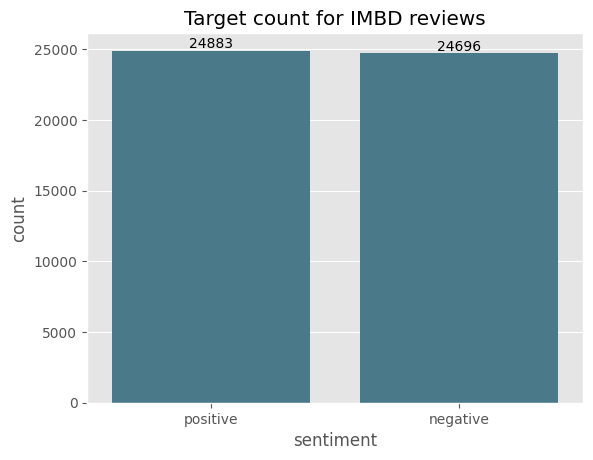

In [296]:
ax = sns.countplot(data=df, x = "sentiment")
plt.title('Target count for IMBD reviews')
ax.bar_label(ax.containers[0], fmt="%d")
plt.show()